In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import tensorflow as tf

from scipy.io import wavfile
from tqdm import tqdm
from IPython.display import Audio
from librosa.feature import mfcc
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score , accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import InputLayer, Conv2D, AveragePooling2D, GlobalAvgPool2D, Dense

In [2]:
dataPath = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

genres = []
genreFolders = []

for folder in os.listdir(dataPath):
    genres.append(folder)
    genreFolders.append(os.path.join(dataPath, folder))
    
print(f'Dataset Contains {len(genres)} Genres:')
print("-----------------------------------")
i = 1
for genre in genres:
    print(f'{i} - {genre}')
    i += 1

Dataset Contains 10 Genres:
-----------------------------------
1 - disco
2 - metal
3 - reggae
4 - blues
5 - rock
6 - classical
7 - jazz
8 - hiphop
9 - country
10 - pop


In [3]:
filePath = []

for genrePath in tqdm(genreFolders):
    for fileName in os.listdir(genrePath):
        path = os.path.join(genrePath, fileName)
        filePath.append(path)

100%|██████████| 10/10 [00:00<00:00, 17.83it/s]


In [4]:
print(f'This Dataset Contains {len(filePath)} Audio Files.')

This Dataset Contains 1000 Audio Files.


In [5]:
# Test one sample from dataset
audio, sample_rate = librosa.load(filePath[100])
Audio(data=audio, rate=sample_rate)

In [6]:
def extract_mfcc(path):
    audio, sr = librosa.load(path)
    mfccs = mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
    return mfccs

def extract_frame_mfccs(path):
    audio, sr = librosa.load(path)
    frames = librosa.util.frame(audio, frame_length=sr*3, hop_length=sr*3)
    
    frame_mfccs = []
    for i in range(frames.shape[1]):
        mfccs = mfcc(y=frames[:,i], sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
        frame_mfccs.append(mfccs)
        
    return frame_mfccs

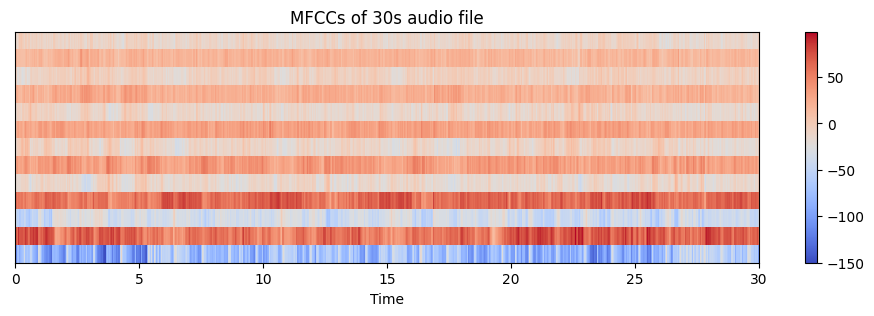

In [7]:
mfccs = extract_mfcc(filePath[100])
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')

plt.colorbar()
plt.title('MFCCs of 30s audio file')
plt.show()

In [8]:
framesMfcc = extract_frame_mfccs(filePath[100])

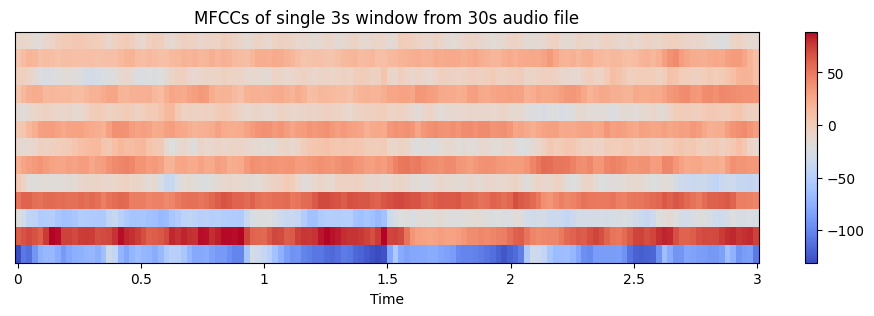

In [9]:
plt.figure(figsize=(12, 3))
librosa.display.specshow(framesMfcc[0], x_axis='time')

plt.colorbar()
plt.title('MFCCs of single 3s window from 30s audio file')
plt.show()

## Data Extraction

In [10]:
X = []
y = []

for file in tqdm(filePath):
    try:
        framesMccs = extract_frame_mfccs(file)
        for frame in framesMccs:
            X.append(frame)
            y.append(file.split('/')[6])
    except Exception:
        pass
        
print(f'Extracted {len(X)} Data - {len(y)} Labels.')

 63%|██████▎   | 626/1000 [02:01<01:13,  5.11it/s]/tmp/ipykernel_31/3149685577.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]

Extracted 9981 Data - 9981 Labels.


In [11]:
reshaped = []

for x in X:
    assert x.shape == (13,130) , f"The Data shape should be (13,130) but got {x.shape}"
    x = x.reshape((26, 65))
    x = np.expand_dims(x, axis=-1)
    reshaped.append(x)
    
X = np.array(reshaped)

In [12]:
LE = LabelEncoder()
y = LE.fit_transform(y)

classes = LE.classes_
print(classes)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=29)

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (7984, 26, 65, 1)
y_train Shape: (7984,)
X_test Shape: (1997, 26, 65, 1)
y_test Shape: (1997,)


## Model Creation

In [14]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(26,65,1)),
    Conv2D(256,(3),padding='valid',activation='relu'),
    Conv2D(256,(3),padding='valid',activation='relu'),
    AveragePooling2D(pool_size=(3),strides=(2),padding='same'),
    Conv2D(256,(3),padding='valid',activation='relu'),
    AveragePooling2D(pool_size=(3),strides=(2),padding='same'),
    Conv2D(512,(4),padding='valid',activation='relu'),
    GlobalAvgPool2D(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(10,activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 63, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 61, 256)       590080    
                                                                 
 average_pooling2d (AverageP  (None, 11, 31, 256)      0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 29, 256)        590080    
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 15, 256)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 12, 512)        2

In [15]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
499/499 [==============================] - 24s 16ms/step - loss: 1.6646 - accuracy: 0.3828
Epoch 2/100
499/499 [==============================] - 8s 16ms/step - loss: 1.3611 - accuracy: 0.4897
Epoch 3/100
499/499 [==============================] - 8s 16ms/step - loss: 1.1873 - accuracy: 0.5630
Epoch 4/100
499/499 [==============================] - 8s 16ms/step - loss: 1.0667 - accuracy: 0.6186
Epoch 5/100
499/499 [==============================] - 8s 16ms/step - loss: 0.9216 - accuracy: 0.6676
Epoch 6/100
499/499 [==============================] - 8s 17ms/step - loss: 0.8513 - accuracy: 0.6931
Epoch 7/100
499/499 [==============================] - 8s 17ms/step - loss: 0.7620 - accuracy: 0.7293
Epoch 8/100
499/499 [==============================] - 8s 17ms/step - loss: 0.6898 - accuracy: 0.7484
Epoch 9/100
499/499 [==============================] - 8s 17ms/step - loss: 0.6173 - accuracy: 0.7819
Epoch 10/100
499/499 [==============================] - 9s 17ms/step - loss: 0.56

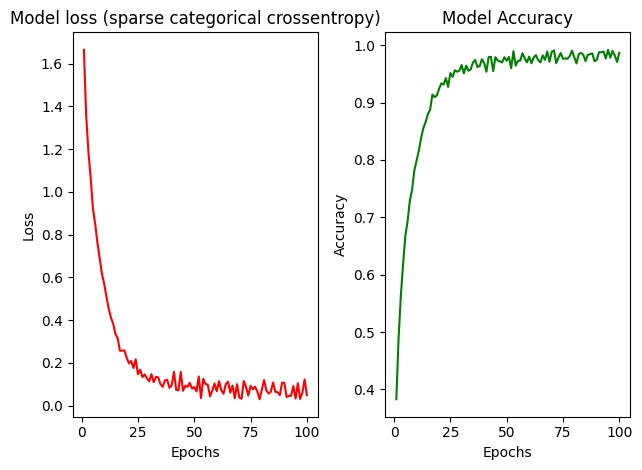

In [16]:
epochs = np.arange(1,101)

plt.subplot(1,2,1)
plt.plot(epochs,history.history['loss'],color='r')
plt.title('Model loss (sparse categorical crossentropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(epochs,history.history['accuracy'],color='g')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [23]:
pred = model.predict(X_test)

preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
    
f1score = f1_score(y_test, preds, average='micro')
accuracy = accuracy_score(y_test, preds)

print(f"The Test Accuracy is {round(accuracy*100, 2)}% \n The F1 Score is {round(f1score*100, 2)}%")

63/63 [==============================] - 1s 11ms/step
The Test Accuracy is 79.82% 
 The F1 Score is 79.82%


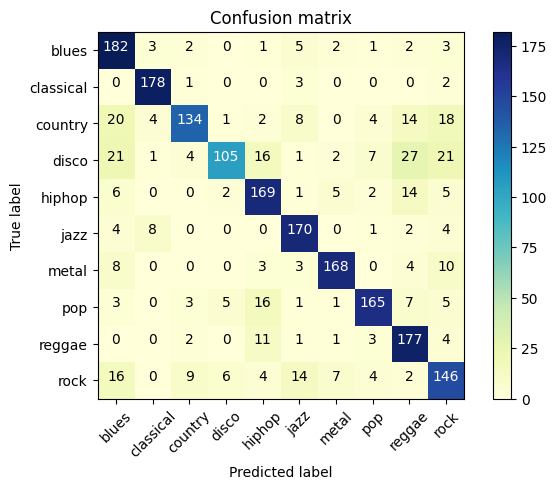

In [31]:
plt.imshow(confusion_matrix(y_test, preds), interpolation='nearest', cmap=plt.cm.YlGnBu)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = confusion_matrix(y_test, preds).max() / 2.
for i, j in np.ndindex(confusion_matrix(y_test, preds).shape):
    plt.text(j, i, format(confusion_matrix(y_test, preds)[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_matrix(y_test, preds)[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
model.save('MusicGenreClassification.h5')